In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = 'cs231n/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment2


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [15]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [17]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.2120479295080622e-05
W3 relative error: 4.5623278736665505e-07
b1 relative error: 4.6600944653202505e-09
b2 relative error: 2.085654276112763e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.904541941902138e-09
W2 relative error: 6.86942277940646e-08
W3 relative error: 3.483989247437803e-08
b1 relative error: 1.4752427965311745e-08
b2 relative error: 1.4615869332918208e-09
b3 relative error: 1.3200479211447775e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 20) loss: 8.863106
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.122000
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.104000
(Epoch 3 / 20) train acc: 0.520000; val_acc: 0.166000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.146000
(Epoch 5 / 20) train acc: 0.840000; val_acc: 0.176000
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.189000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.185000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.181000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.192000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.184000
(Iteration 11 / 20) loss: 0.045467
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.183000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.181000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.180000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.179000
(Epoch 16 / 20) train acc: 1.000000; val_acc: 0.182000
(Epoch 17 / 20) train acc: 1.000000; val_acc: 0.181000
(Epoc

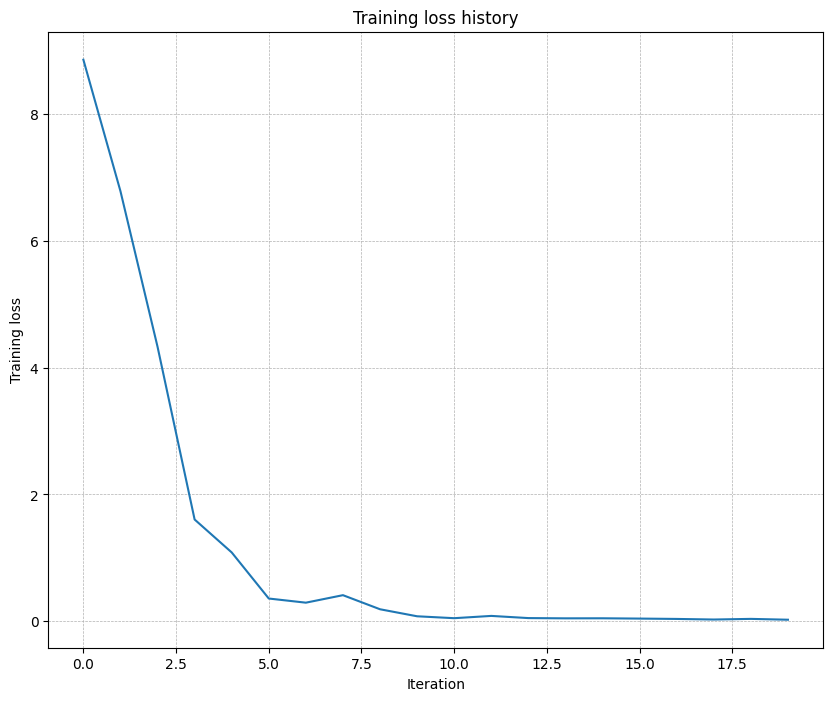

In [18]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 3e-2
learning_rate = 4e-3
model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=50,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.839886
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.098000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.091000
(Epoch 2 / 20) train acc: 0.340000; val_acc: 0.102000
(Epoch 3 / 20) train acc: 0.380000; val_acc: 0.138000
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.147000
(Epoch 5 / 20) train acc: 0.600000; val_acc: 0.132000
(Iteration 11 / 40) loss: 1.070906
(Epoch 6 / 20) train acc: 0.780000; val_acc: 0.168000
(Epoch 7 / 20) train acc: 0.800000; val_acc: 0.153000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.154000
(Epoch 9 / 20) train acc: 0.920000; val_acc: 0.168000
(Epoch 10 / 20) train acc: 0.900000; val_acc: 0.179000
(Iteration 21 / 40) loss: 0.367856
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.155000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.177000
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.176000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.161000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.165000
(Iteration 31 / 40) loss: 

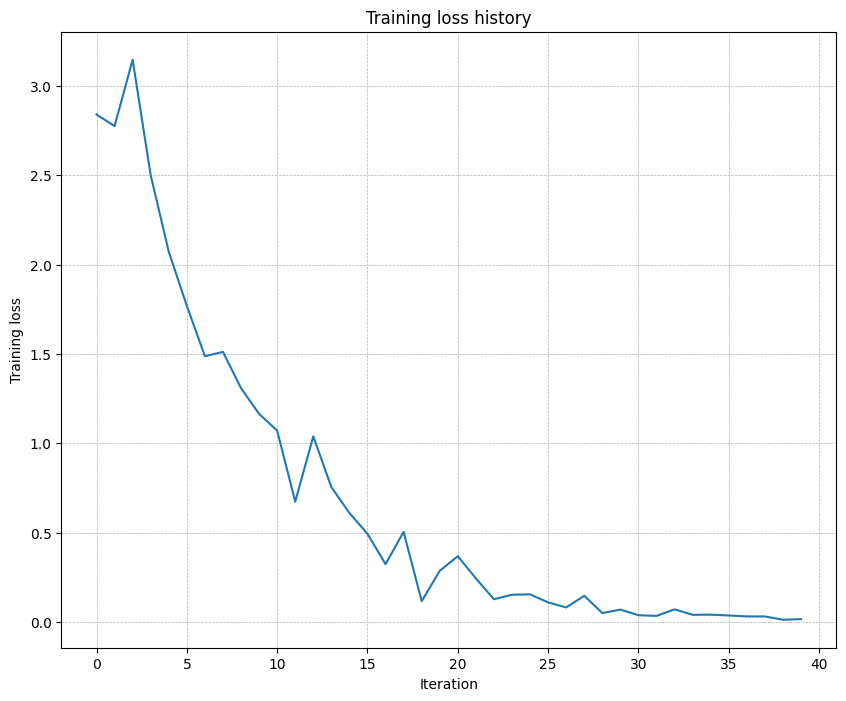

In [6]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 3e-2  # Experiment with this!
weight_scale = 4e-2   # Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1: 
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
Finding the correct scale is harder for Five-layer network.

5-layer network has more weights to adjust and the geometry of the loss function with respect to all these parameters is more complex compared to 3-layer network. Besides, as the model uses the sgd as an optimization rule, the model with deeper layers is more likely to cause gradient vanishing problem or gradient exploding problem with relatively small initial weights or large initial weights, respectively. (gradient product for backpropagation)



# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [ ]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.579686
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.118000
(Epoch 1 / 5) train acc: 0.230000; val_acc: 0.222000
(Iteration 51 / 200) loss: 2.169422
(Epoch 2 / 5) train acc: 0.277000; val_acc: 0.259000
(Iteration 101 / 200) loss: 2.064897
(Epoch 3 / 5) train acc: 0.315000; val_acc: 0.264000
(Iteration 151 / 200) loss: 1.914663
(Epoch 4 / 5) train acc: 0.363000; val_acc: 0.300000
(Epoch 5 / 5) train acc: 0.353000; val_acc: 0.297000
Running with  sgd_momentum
(Iteration 1 / 200) loss: 2.794480
(Epoch 0 / 5) train acc: 0.124000; val_acc: 0.103000
(Epoch 1 / 5) train acc: 0.295000; val_acc: 0.253000
(Iteration 51 / 200) loss: 1.991296
(Epoch 2 / 5) train acc: 0.386000; val_acc: 0.334000
(Iteration 101 / 200) loss: 1.748804
(Epoch 3 / 5) train acc: 0.440000; val_acc: 0.336000
(Iteration 151 / 200) loss: 1.223802
(Epoch 4 / 5) train acc: 0.428000; val_acc: 0.330000
(Epoch 5 / 5) train acc: 0.500000; val_acc: 0.311000


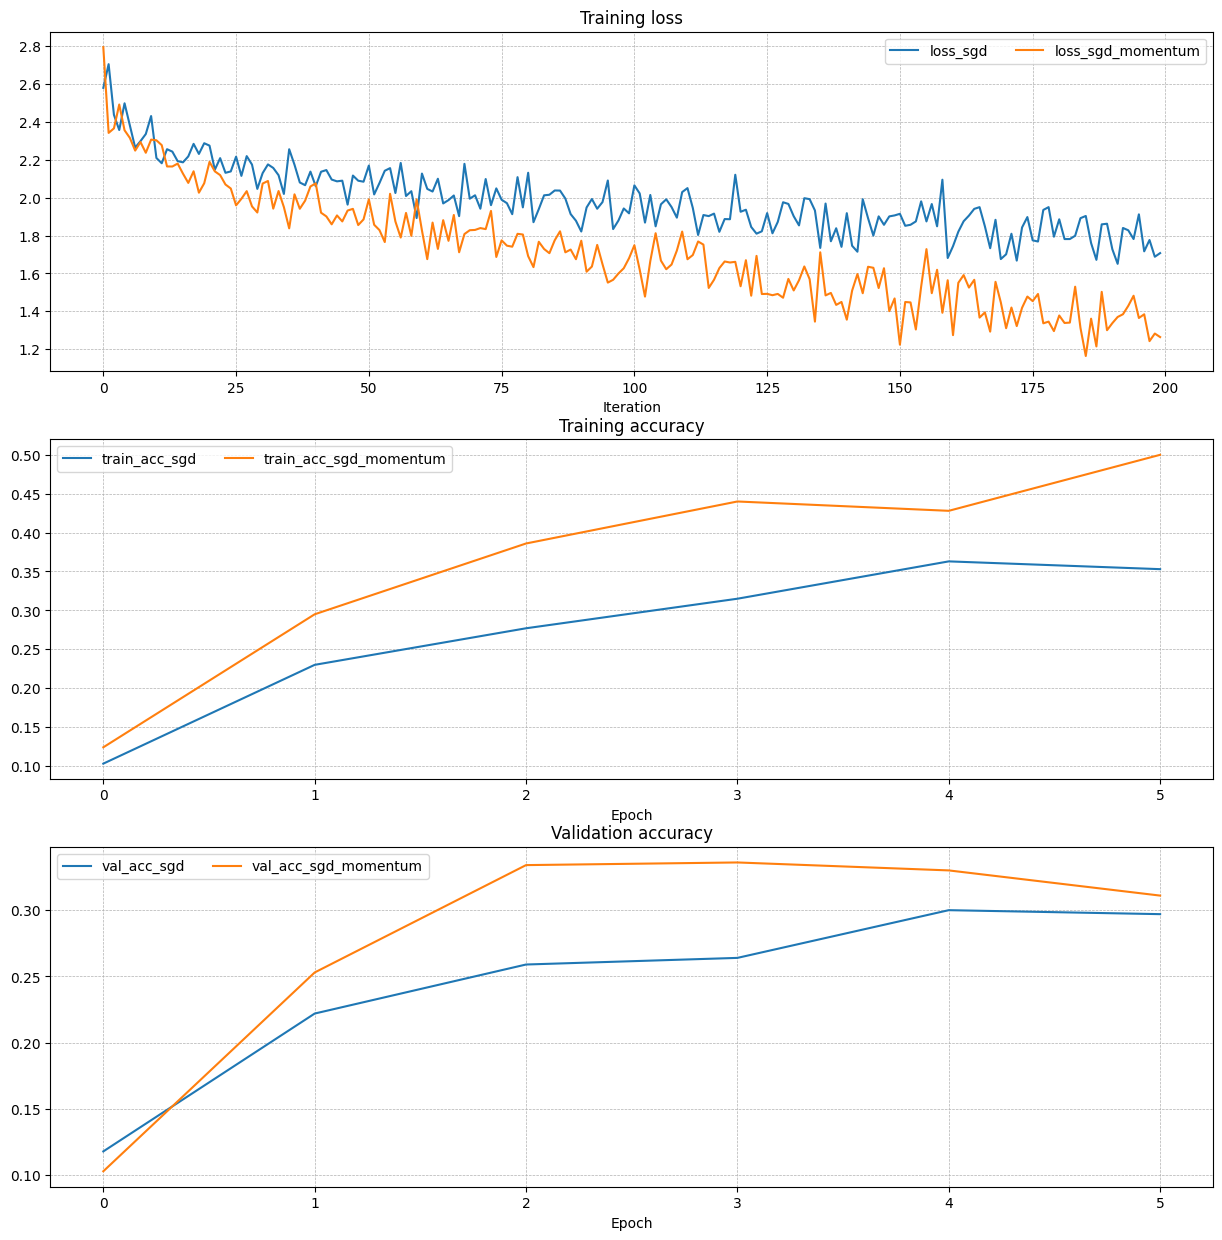

In [25]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2, normalization=None
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        print_every=50,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [ ]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.819714
(Epoch 0 / 5) train acc: 0.118000; val_acc: 0.125000
(Iteration 11 / 200) loss: 2.113233
(Iteration 21 / 200) loss: 1.945289
(Iteration 31 / 200) loss: 1.864436
(Epoch 1 / 5) train acc: 0.382000; val_acc: 0.328000
(Iteration 41 / 200) loss: 1.791987
(Iteration 51 / 200) loss: 1.833568
(Iteration 61 / 200) loss: 1.721805
(Iteration 71 / 200) loss: 1.598979
(Epoch 2 / 5) train acc: 0.417000; val_acc: 0.349000
(Iteration 81 / 200) loss: 1.531435
(Iteration 91 / 200) loss: 1.596346
(Iteration 101 / 200) loss: 1.621471
(Iteration 111 / 200) loss: 1.564796
(Epoch 3 / 5) train acc: 0.489000; val_acc: 0.356000
(Iteration 121 / 200) loss: 1.629568
(Iteration 131 / 200) loss: 1.265449
(Iteration 141 / 200) loss: 1.290802
(Iteration 151 / 200) loss: 1.253509
(Epoch 4 / 5) train acc: 0.561000; val_acc: 0.365000
(Iteration 161 / 200) loss: 1.415152
(Iteration 171 / 200) loss: 1.315874
(Iteration 181 / 200) loss: 1.280451
(Iteration 191 / 200) lo

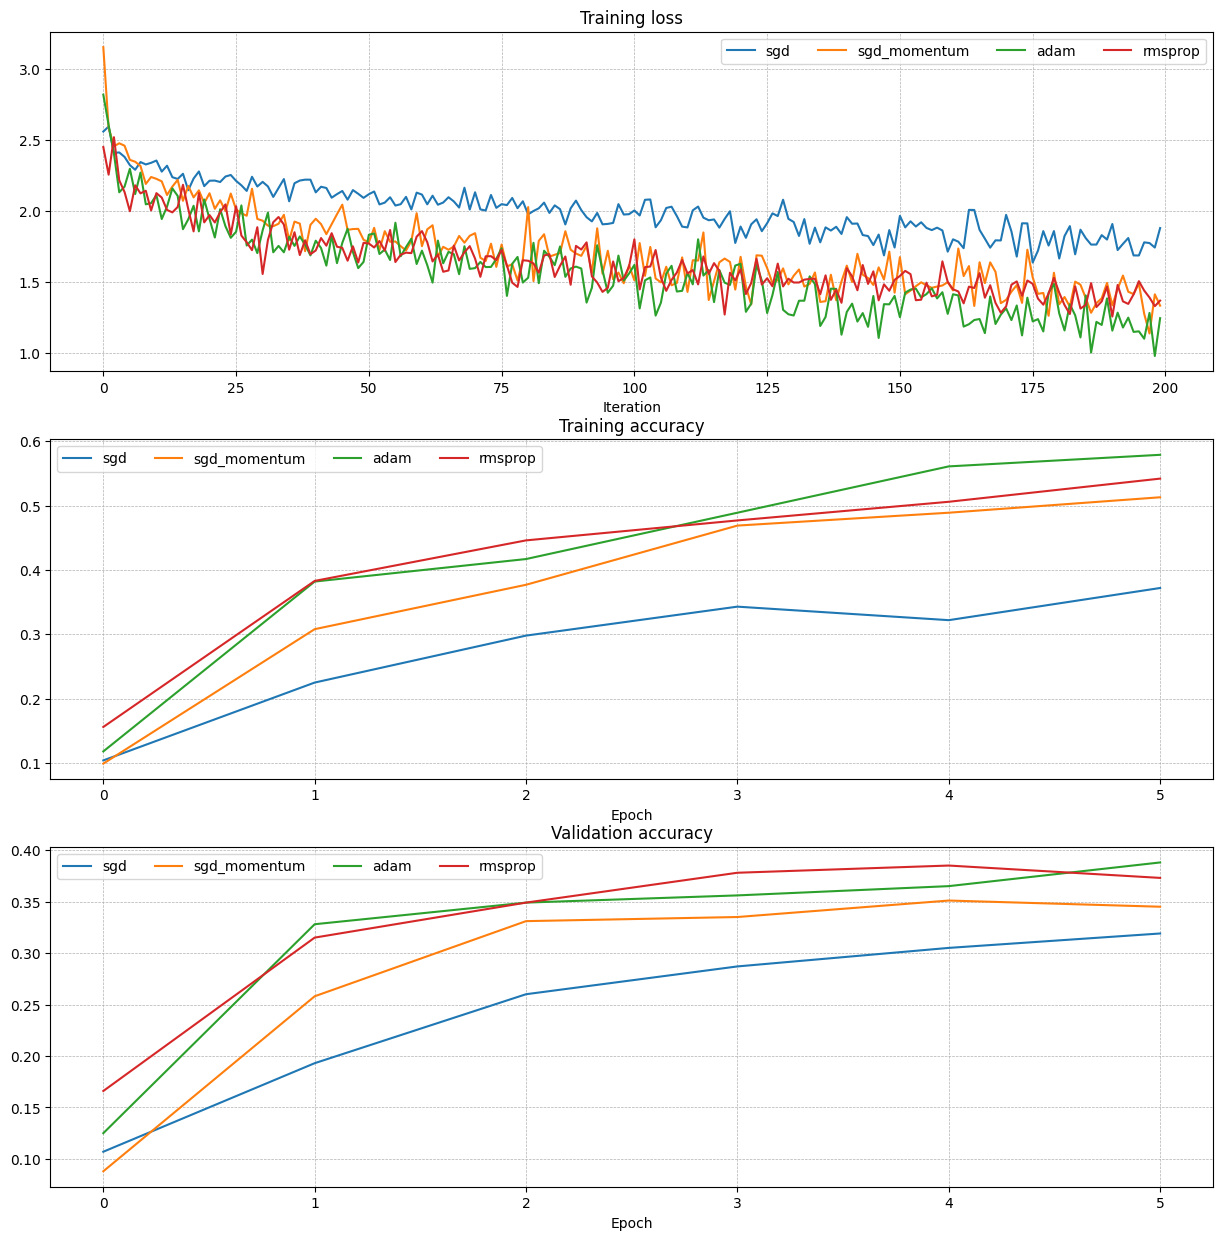

In [11]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 

Adagrad uses element-wise scailing of learning rates by the histrocial sum of squared gradients in each parameter, which is monotonically increasing. As this leads to decay of per-parameter learning rates, step size of update continues to get smaller over the training course. 


Adam, on the other hand, doesn't make the same problem because of the following reasons. 

First, Adam uses the running average of first and second moment of gradients instead of histrocial sum. This prevents the learning rates from monotonically increasing, while still modulating the learning rate based on the magnitude of gradients. 

Second, it contains the bias correction mechanism to handle the issue of zero bias of estimates that can happen in the early stages of learning with running average method. 

# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [ ]:
hidden_dims = [[np.random.randint(50,100) for _ in range(np.random.randint(3,8))] for _ in range(4)]
hidden_dims 
solver.best_val_acc

0.365

In [9]:
best_model = None
best_val = -1

# Random Search
for i in range(20):
    ws = 10**np.random.uniform(-2, -1)
    lr = 10**np.random.uniform(-5, -2)
    reg = 10**np.random.uniform(-3, 3)
    model = FullyConnectedNet([100, 100], weight_scale=ws, reg= reg)

    solver = Solver(model, data,
                    num_epochs=10, batch_size=200,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr
                    },
                    verbose=False)
    solver.train()
    val_accuracy = solver.best_val_acc
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_model = model
    # Print results
    print('lr %e ws %e reg %e val accuracy: %f' % (
                lr, ws, reg, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)

lr 1.109347e-03 ws 1.007112e-02 reg 1.080616e-02 val accuracy: 0.500000
lr 6.665192e-04 ws 2.223139e-02 reg 1.605013e+01 val accuracy: 0.124000


/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/layers.py:143: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(correct_x).sum()/num_train


lr 5.867614e-04 ws 5.985550e-02 reg 6.077665e+01 val accuracy: 0.174000
lr 7.061379e-04 ws 1.327633e-02 reg 2.505687e+02 val accuracy: 0.119000
lr 6.658478e-05 ws 1.379449e-02 reg 1.047376e-01 val accuracy: 0.521000
lr 4.365211e-03 ws 2.711912e-02 reg 3.005237e+02 val accuracy: 0.119000
lr 4.793779e-03 ws 6.050277e-02 reg 2.226436e+00 val accuracy: 0.261000
lr 7.752661e-03 ws 1.847186e-02 reg 6.493051e-02 val accuracy: 0.235000
lr 9.373910e-04 ws 1.087146e-02 reg 1.588134e+00 val accuracy: 0.335000
lr 1.256507e-05 ws 5.284404e-02 reg 2.171858e+00 val accuracy: 0.251000
lr 2.332669e-05 ws 4.377107e-02 reg 3.618768e+01 val accuracy: 0.168000
lr 1.302241e-03 ws 7.393848e-02 reg 8.365916e-03 val accuracy: 0.459000
lr 4.956164e-04 ws 2.458178e-02 reg 7.723914e-01 val accuracy: 0.402000
lr 2.336937e-05 ws 2.679860e-02 reg 1.767033e+00 val accuracy: 0.413000
lr 1.558242e-03 ws 1.575682e-02 reg 1.691460e-02 val accuracy: 0.455000
lr 2.280950e-05 ws 1.663516e-02 reg 1.218605e-01 val accuracy: 0

In [27]:
best_model = None
best_val = -1

# Random Search
ws = 1.379449e-02
lr = 6.658478e-05
reg = 1.047376e-01
model = FullyConnectedNet([100, 100], weight_scale=ws, reg= reg, normalization='batchnorm')

solver = Solver(model, data,
                num_epochs=10, batch_size=200,
                update_rule='adam',
                optim_config={
                    'learning_rate': lr
                },
                verbose=True,
                print_every=10000)
solver.train()
val_accuracy = solver.best_val_acc
if best_val < val_accuracy:
    best_val = val_accuracy
    best_model = model
# Print results
print('lr %e ws %e reg %e val accuracy: %f' % (
            lr, ws, reg, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)

(Iteration 1 / 2450) loss: 5.480303
(Epoch 0 / 10) train acc: 0.093000; val_acc: 0.121000
(Epoch 1 / 10) train acc: 0.385000; val_acc: 0.405000
(Epoch 2 / 10) train acc: 0.454000; val_acc: 0.428000
(Epoch 3 / 10) train acc: 0.519000; val_acc: 0.473000
(Epoch 4 / 10) train acc: 0.532000; val_acc: 0.495000
(Epoch 5 / 10) train acc: 0.518000; val_acc: 0.517000
(Epoch 6 / 10) train acc: 0.522000; val_acc: 0.505000
(Epoch 7 / 10) train acc: 0.550000; val_acc: 0.488000
(Epoch 8 / 10) train acc: 0.584000; val_acc: 0.510000
(Epoch 9 / 10) train acc: 0.570000; val_acc: 0.521000
(Epoch 10 / 10) train acc: 0.577000; val_acc: 0.527000
lr 6.658478e-05 ws 1.379449e-02 reg 1.047376e-01 val accuracy: 0.527000
best validation accuracy achieved: 0.527000


# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [28]:
# with Batch Normalization 

y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.527
Test set accuracy:  0.528
